# Libraries and preparation

refs:
- https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_rag_agent_llama3_local.ipynb
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb?ref=blog.langchain.dev

Starting ollama server and pulling llama3

In [82]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Downloading ollama...
######################################################################## 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [83]:
t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
t.start()

In [84]:
!ollama pull llama3

Error: listen tcp 127.0.0.1:11434: bind: address already in use


[GIN] 2024/07/23 - 13:59:29 | 200 |      46.122µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ [GIN] 2024/07/23 - 13:59:29 | 200 |  509.612386ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest ⠼ pulling manifest 
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB                         
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB                         
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B                         
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B                         
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
removing any unused layers 
success 


In [85]:
t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", "llama3"]),daemon=True)
t2.start()

In [86]:
%%capture --no-stderr
%pip install -U langchain-ai21 langchain-pinecone langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python nomic[local] langchain-text-splitters

[GIN] 2024/07/23 - 13:59:29 | 200 |       25.57µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/07/23 - 13:59:30 | 200 |   26.489764ms |       127.0.0.1 | POST     "/api/show"
[GIN] 2024/07/23 - 13:59:30 | 200 |   23.738275ms |       127.0.0.1 | POST     "/api/generate"


In [87]:
# choosing llm

local_llm = "llama3"

In [88]:
# Tracing and api-keys

import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
_set_env("TAVILY_API_KEY") #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
_set_env("LANGCHAIN_API_KEY") #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
_set_env("PINECONE_API_KEY") #94ef7896-1fae-44d3-b8d2-0bd6f5f664f5
_set_env("AI21_API_KEY") #KlINkh5QKw3hG1b5Hr75YDO7TwGoQvzn
#os.environ["PINECONE_API_KEY"] = getpass.getpass()

# Tools

In [89]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Indexing

Organizing external sources for the llm. Phase of indexing and chunking of docs refs:
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/
- https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/
- Nomic embeddings: https://docs.nomic.ai/atlas/capabilities/embeddings#selecting-a-device

In [90]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_pinecone import PineconeVectorStore
from langchain_ai21 import AI21Embeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls] #text + meta-data on docs
docs_list = [item for sublist in docs for item in sublist] #ci serve l'attributo page_content

# Chunking
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)
index_name = "langchain-test-index"

# Add to vectorDB
vectorstore = PineconeVectorStore.from_documents(
    documents=doc_splits,
    #embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local", device="cuda"),
    embedding=AI21Embeddings(device="cuda"),
    index_name=index_name
)
retriever = vectorstore.as_retriever()

# Query generation (multi-aspects)

In [91]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful assistant that generates multiple
    search queries based on some specified aspects from a single input query. You have to generate ONLY ONE query
    for EACH aspect. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Generate search aspect-queries related to the original query: {original_query}.
    Where the aspects are: {aspects}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["aspects","original_query"],
)

llm = ChatOllama(model=local_llm, format="json", temperature=0)

query_generator = prompt | llm | JsonOutputParser()

# Prova

# original_query = "What about Covid19?"
# generation = query_generator.invoke({"original_query": original_query})
# print(generation)


# # Reciprocal Rank Fusion algorithm
# def reciprocal_rank_fusion(search_results_dict, k=60):
#     fused_scores = {}
#     print("Initial individual search result ranks:")
#     for query, doc_scores in search_results_dict.items():
#         print(f"For query '{query}': {doc_scores}")

#     for query, doc_scores in search_results_dict.items():
#         for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)):
#             if doc not in fused_scores:
#                 fused_scores[doc] = 0
#             previous_score = fused_scores[doc]
#             fused_scores[doc] += 1 / (rank + k)
#             print(f"Updating score for {doc} from {previous_score} to {fused_scores[doc]} based on rank {rank} in query '{query}'")

#     reranked_results = {doc: score for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)}
#     print("Final reranked results:", reranked_results)
#     return reranked_results

# Organizing outputs

In [92]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful assistant that organizes the final output from multiple
    queries based on different aspects in a single query. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the answers: {answers}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["answers"],
)

llm = ChatOllama(model=local_llm, format="json", temperature=0)

final_answer = prompt | llm | JsonOutputParser()
#final_output = final_answer.invoke({"answers": answers})
#print(final_output)

# Retrieval

In [93]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

llm = ChatOllama(model=local_llm, format="json", temperature=0) #higher temperature more likely hallucinations

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
# question = "agent memory"
# docs = retriever.invoke(question)
# doc_txt = docs[1].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

# Generating answer

In [94]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
# question = "agent memory"
# docs = retriever.invoke(question)
# generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

# Hallucinations check

In [95]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
#hallucination_grader.invoke({"documents": docs, "generation": generation})

# Answer check

In [96]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
#answer_grader.invoke({"question": question, "generation": generation})

# Routing

In [97]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents,
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
# question = "llm agent memory"
# docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content
# print(question_router.invoke({"question": question}))

refs:
- https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/

# Control flow (Aspect agents)

refs
- https://www.langchain.com/langgraph

In [98]:
from pprint import pprint
from typing import List, Annotated
import operator

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

### State
class GraphState(TypedDict):
    """
    Represents the state of graph of aspect agents.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    
    query: str
    answers_agent: Annotated[List[str], operator.add]
    my_answer: str
    web_search: str
    documents: List[str]


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print(f"State: {state}")
    queries = state["query"]

    # Retrieval
    documents = retriever.invoke(query)
    return {"documents": documents, "query": query}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": query})
    return {"documents": documents, "query": query, "my_answer": generation, "answers_agent": [generation]}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": query, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "query": query, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": query})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "query": query}


### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    print(f"State: {state}")
    query = state["query"]
    #print(queries)
    source = question_router.invoke({"question": query})
    #print(source)
    #print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    print(f"State: {state}")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"



def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    my_answer = state["my_answer"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": my_answer} #answers_agent[0]
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": query, "generation": my_answer})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

**Building graph with edges**

In [99]:
# Build graph
num_aspects = 2
workflows = []

for i in range(num_aspects):
    workflow = StateGraph(GraphState, config_schema=ConfigSchema)

    # Define the nodes
    workflow.add_node("websearch", web_search)  # web search
    workflow.add_node("retrieve", retrieve)  # retrieve
    workflow.add_node("grade_documents", grade_documents)  # grade documents
    workflow.add_node("generate", generate)  # generatae

    workflow.add_conditional_edges(
        START,
        route_question,
        {
            "websearch": "websearch", #se la risposta è websearch, allora vai al nodo websearch
            "vectorstore": "retrieve", #se la risposta è vectorstore, allora vai al nodo retrieve
        },
    )

    workflow.add_edge("retrieve", "grade_documents")
    workflow.add_conditional_edges(
        "grade_documents",
        decide_to_generate,
        {
            "websearch": "websearch",
            "generate": "generate",
        },
    )
    workflow.add_edge("websearch", "generate")
    workflow.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "not supported": "generate",
            "useful": END,
            "not useful": "websearch",
        },
    )
    
    workflow_compiled = workflow.compile()
    #workflow_compiled.ainvoke(input=[], config={"id_agent":i+1})
    workflows.append(workflow_compiled)
    #print(workflow_compiled.config_specs)

In [100]:
#for i in range(num_aspects):
#    print(workflows[i].config_specs)

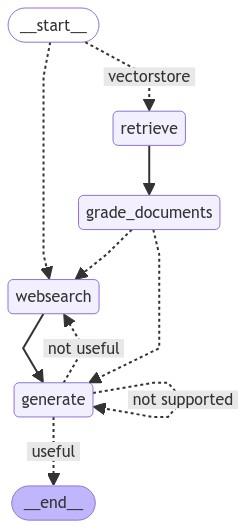

In [101]:
from IPython.display import Image, display

display(Image(workflows[0].get_graph().draw_mermaid_png()))

In [103]:
# Test

inputs = {"query": "What about COVID19?"}
#print(workflows[0].stream(inputs))
for output in workflows[0].stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["my_answer"])
#workflows[0].invoke({"queries": ["What about COVID19?"]},{"id_agent":1})

---ROUTE QUESTION---
State: {'query': 'What about COVID19?', 'answers_agent': []}
[GIN] 2024/07/23 - 14:00:39 | 200 |  577.526606ms |       127.0.0.1 | POST     "/api/chat"
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
State: {'query': 'What about COVID19?', 'answers_agent': [], 'my_answer': None, 'web_search': None, 'documents': None}
'Finished running: websearch:'
---GENERATE---
State: {'query': 'What about COVID19?', 'answers_agent': [], 'my_answer': None, 'web_search': None, 'documents': [Document(page_content='CDC’s\xa0COVID-19 hospital admission levels help individuals and communities decide when to take action to protect yourself and others\xa0based on the latest data and information from your area.\n CDC is working with state and local public health officials to monitor the spread of all variants, including Omicron.\nSearch for and find historical COVID-19 pages and files. In addition to staying up to date with\xa0COVID-19 vaccines and basic health and hygiene practices l

# Application

In [146]:
from typing import Annotated
import operator
from langgraph.constants import Send

#Reducer Custom
def custom(): #reducer custom #cancella quello che c'è prima e rimpiazza

### Super Graph State
class SuperGraphState(TypedDict):
    """
    Represents the state of our super-graph.

    Attributes:
        question: question
        generation: LLM generation
        agents_answer: generation of agents
        answer: the final answer
    """
    
    aspect: Annotated[str,custom]
    question: str
    query: Annotated[str,custom]
    answers_agent: Annotated[str, operator.add]
    final_answer: str


def generate_queries(state):
    """
    Generate multi-aspect queries from the starting question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the multi aspect queries
    """
    print("---GENERATE MULTI-ASPECTS QUERIES---")
    print(f"State: {state}")
    question = state["question"]
    aspects = ["Finance", "Society"]

    generation = query_generator.invoke({"aspects": aspects, "original_query": question})
    print(list(generation.values()))
    return {"queries": list(generation.values())}

def organize_outputs(state):
    """
    Organize the outputs of the agents.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains the final answer to give to user
    """
    print("---ORGANIZE OUTPUTS---")
    print(f"State: {state}")
    answers_agent = state["answers_agent"]

    final_output =final_answer.invoke({"answers": answers_agent})
    return {"final_answer": final_output}

master_flow = StateGraph(SuperGraphState)

# Define the nodes
master_flow.add_node("generate_queries", generate_queries)
for i in range(num_aspects):
    master_flow.add_node(f"send_query_{i}", lambda state: {"query":state['queries'][i], "prova":"La cipolla"}) 
    #Send(f"aspect_agent_node_{i+1}", {"query":state['queries'][i]})
master_flow.add_node("organize_queries", organize_outputs)
#master_flow.add_node(f"aspect_agent_node",workflows[0])
for i in range(num_aspects):
    master_flow.add_node(f"aspect_agent_node_{i+1}",workflows[i])

# Build graph
master_flow.add_edge(START, "generate_queries")
#master_flow.add_edge("generate_queries", "aspect_agent_node")
#master_flow.add_edge("aspect_agent_node", "organize_queries")
for i in range(num_aspects):
    master_flow.add_edge("generate_queries", f"send_query_{i}")
for i in range(num_aspects):
    master_flow.add_edge(f"send_query_{i}", f"aspect_agent_node_{i+1}")
for i in range(num_aspects):
    master_flow.add_edge(f"aspect_agent_node_{i+1}", "organize_queries")
master_flow.add_edge("organize_queries", END)

app = master_flow.compile()

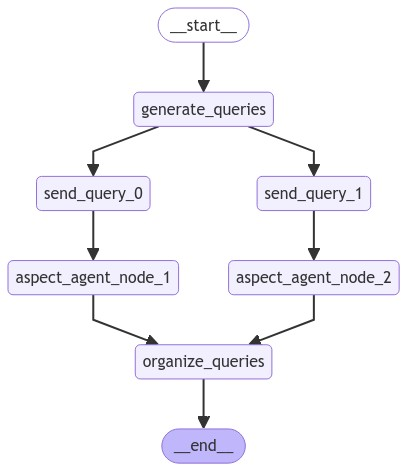

In [147]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(app.get_graph().draw_mermaid_png()))

In [148]:
# Test

inputs = {"question": "What about COVID19?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["final_answer"])

---GENERATE MULTI-ASPECTS QUERIES---
State: {'question': 'What about COVID19?', 'queries': None, 'answers_agent': [], 'final_answer': None, 'prova': ''}


time=2024-07-23T14:43:07.882Z level=WARN source=server.go:756 msg="Prompt does not specify that the LLM should response in JSON, but JSON format is expected. For best results specify that JSON is expected in the system prompt."


[GIN] 2024/07/23 - 14:43:08 | 200 |  758.704309ms |       127.0.0.1 | POST     "/api/chat"
['COVID-19 economic impact', 'COVID-19 pandemic effects on society']
'Finished running: generate_queries:'
'Finished running: send_query_1:'
'Finished running: send_query_0:'
---ROUTE QUESTION---
State: {'question': 'What about COVID19?', 'queries': ['COVID-19 economic impact', 'COVID-19 pandemic effects on society'], 'answers_agent': [], 'final_answer': None, 'prova': 'La cipollaLa cipolla'}
---ROUTE QUESTION---
State: {'question': 'What about COVID19?', 'queries': ['COVID-19 economic impact', 'COVID-19 pandemic effects on society'], 'answers_agent': [], 'final_answer': None, 'prova': 'La cipollaLa cipolla'}


KeyError: 'query'